# Final Project Quantitative Macroeconomics:

## Part 2: Solving A Lake Model of Employment and Unemployment. 

#### Jorge Batanero Rodríguez

In [2]:
 #!pip install --upgrade quantecon

In [2]:
import numpy as np
from quantecon import MarkovChain
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from scipy.optimize import brentq
from quantecon.distributions import BetaBinomial
from numba import jit
from numba.experimental import jitclass

## Model

The Lake model is a simple tool for modelling unemployment, it is called lake model, because we can interpret being unemployed and being employed as being in two different lake, in this simple model I'm going to assume that the parameters that determine the flows between employment and unemployment are exogenous.

First, let's define some needed parameters:

-$\lambda$:job finding rate for currently unemployed workers.

-$\alpha$: dismissal rate for currently employed workers.

-$b$: entry rate into the labor force.

-$d$: exit rate from the labor force.

-$g=b-d$: growth rate of the labor force.


Let me define the following aggregates:

-$E_t$: total employed in time t.

-$U_t$: total unemployed in time t.

-$N_t$: Total workers in the labor force.

Therefore the employment and unemployment rates are the followings:

-$e_t:=\frac{E_t}/{N_t}$: Employment rate.

-$u_t:=\frac{U_t}/{N_t}$: Unemployment rate.



Now we define the law of motion for the aggregate variables, $E_t$, $U_t$ and $N_t$. 

From the employed workers at time t $E_t$:

-$(1-d)E_t$ remain in the labor force.

-$(1-\alpha)(1-d)E_t$ remain employed.

From the unemployed workers at time t $U_t$.

-$(1-d)U_t$ remain in the labor force.

-$\lambda(1-d)U_t$ will become employed.

Therefore, the number of workers who will be employed and unemployed at date t + 1 are given by:

\begin{align}
  &  E_{t+1}=(1-d)(1-\alpha)E_t+(1-d)\lambda U_t \\
  &  U_{t+1}=(1-d)\alpha E_t+(1-d)(1-\lambda)U_t+b(E_t+U_t)
\end{align}

Where $b(E_t+U_t)$ is mass of new workers entering in the labor force.

The total stock of Workers in t+1:

\begin{align}
N_{t+1}=(1-d+b)N_t=(1+g)N_t
\end{align}

Writting this low of motions in matrix form:

\begin{align}
    X_{t+1}=A X_t 
\end{align}

Where $X_t$ and A are defined as:

\begin{align}
& X_t:=\begin{pmatrix}
U_t \\
E_t
\end{pmatrix} 
\end{align}
\begin{align}
 A:=\begin{pmatrix}
(1-d)(1-\lambda)+b & (1-d)\alpha+b \\
(1-d)\lambda & (1-d)(1-\alpha)
\end{pmatrix} 
\end{align}

We can write this low of motions in terms of rates dividing both sides by $N_{t+1}$:

\begin{align}
& \begin{pmatrix}
\frac{U_{t+1}}{N_{t+1}} \\
\frac{E_{t+1}}{N_{t+1}}
\end{pmatrix}=\frac{1}{1+g}A \begin{pmatrix}
\frac{U_t}{N_t} \\
\frac{E_t}{N_t}
\end{pmatrix}
\end{align}

To simplify the notation let me write it as follows:

\begin{align}
    x_{t+1}=\hat{A}x_t \quad \text{where} \hat{A}:=\frac{1}{1+g}A
\end{align}

## Implementation 

We are going to create a class for the LakeModel, that will do the following:

1 Store the know parameters $\alpha, \lambda,b ,d$.

2 Compute and store the objects that depend on the know parameters such as g, A, $\hat{A}$.

3 Simulate the dynamics for the stoks and rates.

4 Compute the steady state of the rates.


In [3]:
class LakeModel:
    """
    Solves the lake model and computes dynamics of unemployment stocks and
    rates.
    Parameters:
    ------------
    λ : scalar The job finding rate for currently unemployed workers
    α : scalar The dismissal rate for currently employed workers
    b : scalar Entry rate into the labor force
    d : scalar Exit rate from the labor force
    """
    def __init__(self, λ=0.283, α=0.013, b=0.0124, d=0.00822):
        self._λ, self._α, self._b, self._d = λ, α, b, d
        self.compute_derived_values()
        
    def compute_derived_values(self):
        # Unpack names to simplify expression
        λ, α, b, d = self._λ, self._α, self._b, self._d
        self._g = b - d
        self._A = np.array([[(1-d) * (1-λ) + b, (1 - d) * α + b],
                            [        (1-d) * λ,(1 - d) * (1 - α)]])
        self._A_hat = self._A / (1 + self._g)
        
    @property
    def g(self):
        return self._g
    @property
    def A(self):
        return self._A
    @property
    def A_hat(self):
        return self._A_hat
    @property
    def λ(self):
        return self._λ
    @λ.setter
    def λ(self, new_value):
        self._λ = new_value
        self.compute_derived_values()
    @property
    def α(self):
        return self._α
    @α.setter
    def α(self, new_value):
        self._α = new_value
        self.compute_derived_values()
    @property
    def b(self):
        return self._b
    @b.setter
    def b(self, new_value):
        self._b = new_value
        self.compute_derived_values()
    @property
    def d(self):
        return self._d
    @d.setter
    def d(self, new_value):
        self._d = new_value
        self.compute_derived_values()  
        
    def rate_steady_state(self, x_0, ε=1e-6):
        """
        Find the steady state of x_{t+1}=\hat{A}x_t
        That is return the steady state of the unemployment
        and employment rate
        """
   
        x = 0.5 * np.ones(2)
        error = ε + 1
        while error > ε:
            new_x = self.A_hat@x
            error = np.max(np.abs(new_x - x))
            x = new_x
        return x
        
    def simulate_stock_path(self, X0, T):
        """
        Simulate the sequence of employment and unemployment aggregates
        X0 contains the initial conditions of E_0 and U_0
        X contains the whole sequence of E_t and U_t from t to T
        """
    
        X = np.atleast_1d(X0) # Recast as array just in case
        for t in range(T):
            yield X
            X = self.A@X
            
    def simulate_rate_path(self, x0, T):
        """
        Simulate the sequence of employment and unemployment rates
        X0 contains the initial conditions of e_0 and u_0
        x contains the whole sequence of e_t and u_t from t to T
        """
   
        x = np.atleast_1d(x0) # Recast as array just in case
        for t in range(T):
            yield x
            x = self.A_hat@x  

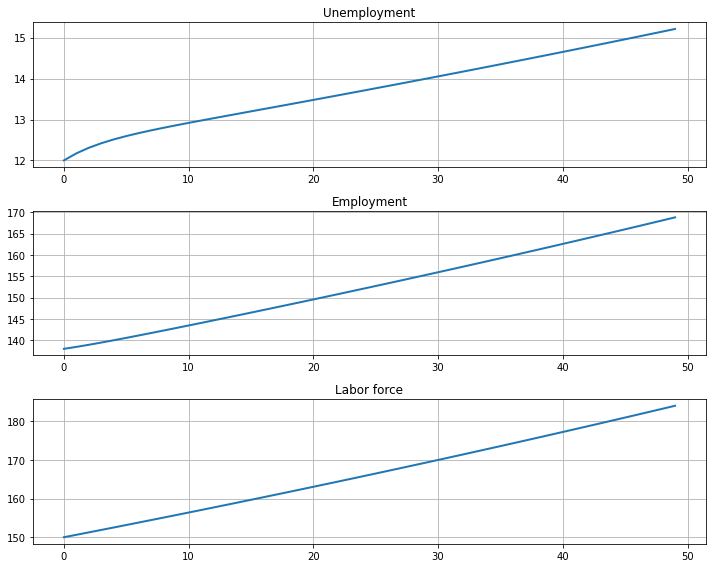

In [4]:
# Here I'm going to simulate the sequence of aggregates 


lm = LakeModel() # Create an instance fot the lake model
N_0 = 150 # Population
e_0 = 0.92 # Initial employment rate
u_0 = 1 - e_0 # Initial unemployment rate
T = 50 # Simulation length
U_0 = u_0 * N_0
E_0 = e_0 * N_0
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
X_0 = (U_0, E_0)
X_path = np.vstack(tuple(lm.simulate_stock_path(X_0, T)))
axes[0].plot(X_path[:, 0], lw=2)
axes[0].set_title('Unemployment')
axes[1].plot(X_path[:, 1], lw=2)
axes[1].set_title('Employment')
axes[2].plot(X_path.sum(1), lw=2)
axes[2].set_title('Labor force')
for ax in axes:
    ax.grid()
plt.tight_layout()
plt.show()

We can see in the graphs that the aggregates do not converge, because they grow at a rate g.

Now I check if the if the  employment and unemployment rates converge to some steady state. They will converge if exist $\bar{x}$ such that:

\begin{align}
  &  \bar{x}=\hat{A}\bar{x} \\
   & \bar{e}+\bar{u}=1
\end{align}

To check this we can look at the eigen values of the transition matrix $\hat{A}$.

In [5]:
lm = LakeModel()
e, f = np.linalg.eigvals(lm.A_hat)
abs(e), abs(f)

(0.6953067378358462, 1.0)

From the Markov process theory we know that if the transition matrix has only one eigenvalue equal to 1 and all the
other eigenvalues have modulus strictly smaller than 1, then the limiting matrix, in this case the stationary vector of $\bar{x}$ is unique.

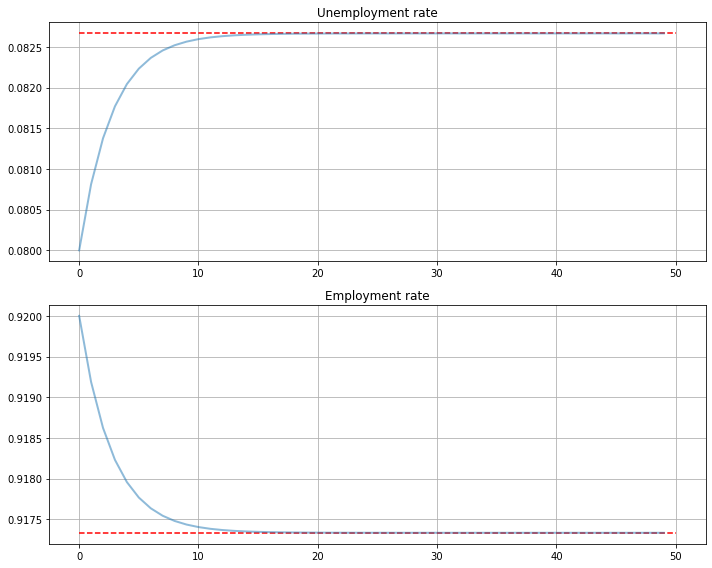

In [6]:
# Now I look at the convergence of the
# employment and unemployment rates
lm = LakeModel()
e_0 = 0.92 # Initial employment rate
u_0 = 1 - e_0 # Initial unemployment rate
T = 50 # Simulation length


# Set the vector of initial conditions
x_0 = (u_0, e_0) 
#Compute the steady state
xbar = lm.rate_steady_state(x_0)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
# Solve for the transition
x_path = np.vstack(tuple(lm.simulate_rate_path(x_0, T)))

#Plot 
titles = ['Unemployment rate', 'Employment rate']
for i, title in enumerate(titles):
    axes[i].plot(x_path[:, i], lw=2, alpha=0.5)
    axes[i].hlines(xbar[i], 0, T, 'r', '--')
    axes[i].set_title(title)
    axes[i].grid()
    plt.tight_layout()
plt.show()

Now I focus the analysis on the individual employment dynamics, a worker can be in two states, employed ($s_t=1$) or unemployed ($s_t=0$). Let me assume that $b=d=0$, therefore there are no individuals leaving the labor force or new individuals entering in the labor force. In this case the transition matrix from one state to another for an individual is given by:

\begin{align}
P= \begin{pmatrix}
(1-\lambda) & \lambda \\
\alpha & (1-\alpha)
\end{pmatrix}
\end{align}

Since $\alpha \in (0,1)$ and $\lambda \in (0,1)$ we can be sure that this markov process has a stationary distribution and it is unique. Let me call $\psi_t$ the marginal distribution of the states employment and unemployment for a given worker in time t, where:

\begin{align*}
    \psi_{t+1}=\psi{t} P
\end{align*}

We can compute the average time that an infinitely lived worker spend employed and unemployed as follows:

\begin{align}
    & \bar{s}_{u,T}:=\frac{1}{T}\sum_{t=1}^T \mathbb{1}\{s_t=0\} \\
    & \bar{s}_{e,T}:=\frac{1}{T}\sum_{t=1}^T \mathbb{1}\{s_t=1\}
\end{align}

These are the fraction of time that a worker spends unemployed and employed up to period T, again since $\alpha \in (0,1)$ and $\lambda \in (0,1)$ we can be sure that P is ergodic and therefore:

\begin{align}
    &  \lim_{T\to \infty}\bar{s}_{u,T}=\psi[0]\\
    & \lim_{T\to \infty} \bar{s}_{e,T}=\psi[1]
\end{align}
    
Therefore, an infinitely livel worker stays unmemployed exaxtly the same proportion of time as the stationary unemployment rate. 

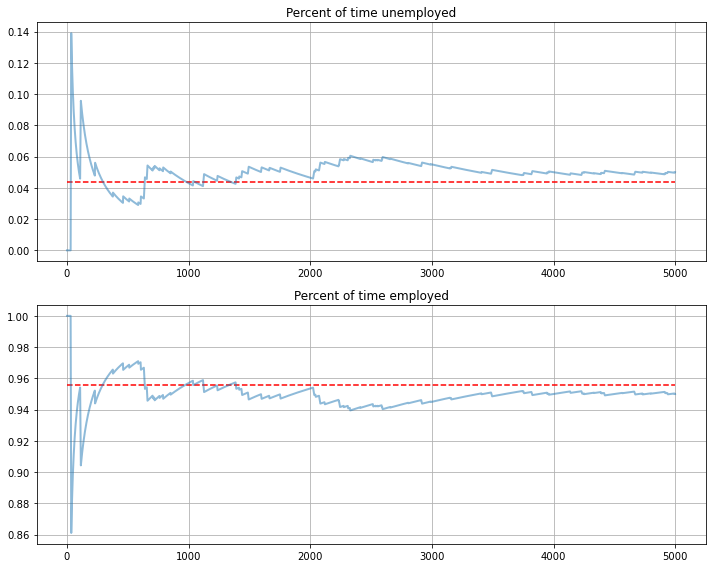

In [7]:
lm = LakeModel(d=0, b=0)
T = 5000 # Simulation length
α, λ = lm.α, lm.λ
P = [[1 - λ, λ],
[ α, 1 - α]]
mc = MarkovChain(P)
e_0 = 0.92 # Initial employment rate to compute the aggregate steady state
u_0 = 1 - e_0 # Initial unemployment rate to compute the aggregate steady state
x_0 = (u_0, e_0) 
xbar = lm.rate_steady_state(x_0)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
s_path = mc.simulate(T, init=1)
s_bar_e = s_path.cumsum() / range(1, T+1)
s_bar_u = 1 - s_bar_e
to_plot = [s_bar_u, s_bar_e]
titles = ['Percent of time unemployed', 'Percent of time employed']

for i, plot in enumerate(to_plot):
    axes[i].plot(plot, lw=2, alpha=0.5)
    axes[i].hlines(xbar[i], 0, T, 'r', '--')
    axes[i].set_title(titles[i])
    axes[i].grid()
plt.tight_layout()
plt.show()

We can see the graphs that takes a lot of periods to converge to the stationary dsitribution.

# Joining McCall and Lake Model

Now I endogenize the transition from unemployment to employment, this transition will be determine by the McCall Model, that I presented in the previous section.

Let me recover some parameters from McCall Model:

-$\beta$: Discount factor.

-$\gamma$: Offer arrival rate.

-$c$: Unemployment compensation.

-$\alpha$: The same separation rate as in Lake Model.

Now assume that all workers inside a lake model take their decision of working or not following the McCall Model. Then their optimal decision rule determine the probability $\lambda$ of leaving unemployment, $\lambda$ is now given by the following expression:

\begin{align}
    \lambda = \gamma \mathbb{P}\{\omega_t \ge \bar{\omega}\}=\gamma \sum_{\omega'\ge \bar{\omega}}p(\omega')
\end{align}

Under this environment, I can add another element to the model, since the reservation wage and therefore the employment decisions depend on the compensation $c$, I can introduce a government that chooses the compensation c and finance this compensation through a lump-sum tax $\tau$. To have balanced budget, I have to impose $\tau=uc$. The lump-sum tax will apply to everyone, so an employed worker will have a post-tax income equal to $\omega-\tau$, and an unemployed worker $c-\tau$.

So for each couple $(c,\tau)$, there is a different reservation, by changing the fiscal policy, I can change the unemployment rate of the steady state $u(c,\tau)$.

To evaluate the different fiscal policies, I need a welfare function, I will set a steady state criterion, that is I will focus on maximizing the welfare at the steady state, the welfare function will be given by:

\begin{align}
    W:=e\mathbb{E}[V|employed]+u U
\end{align}

Where $\mathbb{E}[V|employed]$ is the expected utility of being employed and U the utility of unemployed.

I will assume a constant risk aversion utility function for the workers.

In [73]:
# Definining the utility function

def u(c,σ):
     # Here c refers to consumption not to the compensation 
    if c>0:
        return (c**(1 - σ) - 1) / (1 - σ)
    else:
    # If consumption is negative set a very negative utility
        return -10e6
# Creating a class for the McCall Model
class McCallModel:
    """
    Stores the parameters and functions associated with a given model.
    """
    def __init__(self,
                α=0.2, # Job separation rate
                β=0.98, # Discount rate
                γ=0.7, # Job offer rate
                c=6.0, # Unemployment compensation
                σ=2.0, # Utility parameter
                w_vec=None, # Possible wage values
                p_vec=None): # Probabilities over w_vec 
        self.α, self.β, self.γ, self.c = α, β, γ, c
        self.σ = σ
        
        # Add a default wage vector and probabilities over the vector using
        # the beta-binomial distribution
        if w_vec is None:
            n = 60 # Number of possible outcomes for wage
            # Wages between 10 and 20
            self.w_vec = np.linspace(10, 20, n)
            a, b = 600, 400 # Shape parameters
            dist = BetaBinomial(n-1, a, b)
            self.p_vec = dist.pdf()
        else:
            self.w_vec = w_vec
            self.p_vec = p_vec
            

def _update_bellman(α, β, γ, c, σ, w_vec, p_vec, V, V_new, U):
    """
    Note that V_new is modified in place (i.e, modified by this function). The new value of U
    is returned.
    """
    for w_idx, w in enumerate(w_vec):
    # w_idx indexes the vector of possible wages
        V_new[w_idx] = u(w, σ) + β * ((1 - α) * V[w_idx] + α * U)
        U_new = u(c, σ) + β * (1 - γ) * U + β * γ * np.sum(np.maximum(U, V) * p_vec)
    return U_new

def solve_mccall_model(mcm, ε=1e-5, maxitera=2000):
    """
    Iterates to convergence on the Bellman equations 
    Parameters
    ----------
    mcm : an instance of McCallModel
    ε : float error tolerance
    maxitera : int the maximum number of iterations
    """
    V = np.ones(len(mcm.w_vec)) # Initial guess of V same length of wage vector
    V_new = np.empty_like(V) # To store updates to V, with same dimension as V
    U = 1 # Initial guess of U
    i = 0
    error = ε + 1
    while error > ε and i < maxitera:
        U_new = _update_bellman(mcm.α, mcm.β, mcm.γ, mcm.c, mcm.σ, mcm.w_vec, mcm.p_vec, V, V_new, U)
        error_1 = np.max(np.abs(V_new - V))
        error_2 = np.abs(U_new - U)
        error = max(error_1, error_2)
        V[:] = V_new
        U = U_new
        i += 1
    return V, U

In [74]:
def compute_reservation_wage(mcm, return_values=False):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that V(w) > U.
    If V(w) > U for all w, then the reservation wage w_bar is set to
    the lowest wage in mcm.w_vec.
    If v(w) < U for all w, then w_bar is set to np.inf.
    Parameters
    ----------
    mcm : an instance of McCallModel
    return_values : bool (optional, default=False) Return the value functions as well Returns
    -------
    w_bar : scalar The reservation wage
    """
    V, U = solve_mccall_model(mcm)
    w_idx = np.searchsorted(V - U, 0)
    if w_idx == len(V):
        w_bar = np.inf
    else:
        w_bar = mcm.w_vec[w_idx]
    if return_values == False:
        return w_bar
    else:
        return w_bar, V, U

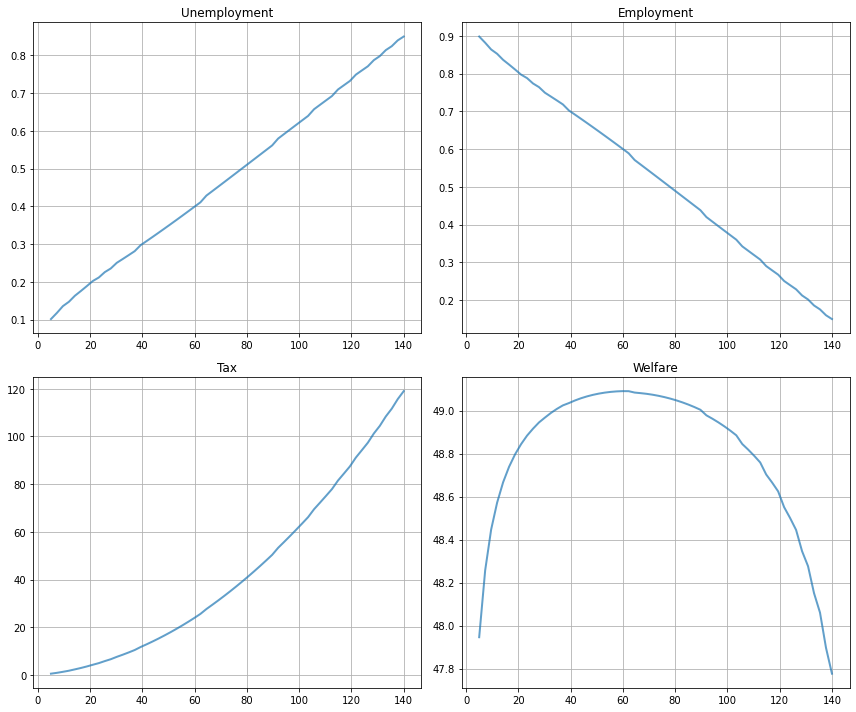

In [76]:
# Some global variables that will stay constant
α = 0.013
α_q = (1-(1-α)**3) # Quarterly (α is monthly)
b = 0.0124
d = 0.00822
β = 0.98
γ = 1.0
σ = 2.0

# The default wage distribution --- a discretized lognormal
log_wage_mean=20
wage_grid_size=200
max_wage = 170
logw_dist = norm(np.log(log_wage_mean), 1)
w_vec = np.linspace(1e-8, max_wage, wage_grid_size + 1)
cdf = logw_dist.cdf(np.log(w_vec))
pdf = cdf[1:] - cdf[:-1]
p_vec = pdf / pdf.sum()
w_vec = (w_vec[1:] + w_vec[:-1]) / 2

def compute_optimal_quantities(c, τ):
    """
    Compute the reservation wage, job finding rate and value functions
    of the workers given c and τ.
    """
    mcm = McCallModel(α=α_q,
                    β=β,
                    γ=γ,
                    c=c-τ, # Post tax compensation
                    σ=σ,
                    w_vec=w_vec-τ, # Post tax wages
                    p_vec=p_vec)
    w_bar, V, U = compute_reservation_wage(mcm, return_values=True)
    λ = γ * np.sum(p_vec[w_vec - τ > w_bar])
    return w_bar, λ, V, U

def compute_steady_state_quantities(c, τ):
    """
    Compute the steady state unemployment rate given c and τ using optimal
    quantities from the McCall model and computing corresponding steady
    state quantities
    """
    w_bar, λ, V, U = compute_optimal_quantities(c, τ)
    # Compute steady state employment and unemployment rates
    lm = LakeModel(α=α_q, λ=λ, b=b, d=d)
    e_0 = 0.92 # Initial employment rate
    u_0 = 1 - e_0 # Initial unemployment rate
    x_0=(u_0, e_0)
    x = lm.rate_steady_state(x_0)
    u, e = x
    # Compute steady state welfare
    w = np.sum(V * p_vec * (w_vec - τ > w_bar)) / np.sum(p_vec * (w_vec -τ > w_bar))
    welfare = e * w + u * U
    return e, u, welfare

def find_balanced_budget_tax(c):
    """
    Find the tax level that will induce a balanced budget.
    """
    def steady_state_budget(t):
        e, u, w = compute_steady_state_quantities(c, t)
        return t - u * c
    τ = brentq(steady_state_budget, 0.0, 0.9 * c)
    return τ

# Levels of unemployment insurance we wish to study
c_vec = np.linspace(5, 140, 60)
tax_vec = []
unempl_vec = []
empl_vec = []
welfare_vec = []

for c in c_vec:
    t = find_balanced_budget_tax(c)
    e_rate, u_rate, welfare = compute_steady_state_quantities(c, t)
    tax_vec.append(t)
    unempl_vec.append(u_rate)
    empl_vec.append(e_rate)
    welfare_vec.append(welfare)
    
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plots = [unempl_vec, empl_vec, tax_vec, welfare_vec]
titles = ['Unemployment', 'Employment', 'Tax', 'Welfare']

for ax, plot, title in zip(axes.flatten(), plots, titles):
    ax.plot(c_vec, plot, lw=2, alpha=0.7)
    ax.set_title(title)
    ax.grid()
plt.tight_layout()
plt.show()

Another thing that we can also look is how does the model converge from the initial steady state to a new steady steady state if we change some parameter.  

In [15]:
# I begin by setting the initial values equal to the initial steady state
lm = LakeModel()
e_0 = 0.92 # Initial employment rate
u_0 = 1 - e_0 # Initial unemployment rate
y_0=(u_0, e_0) # Initial condition to compute the initial steady state
x_0 = lm.rate_steady_state(y_0)
print(f"Initial Steady State: {x_0}")
# Set the initial population
N0 = 100
# Set the number of periods to plot
T = 50
# Now I change λ=0.2, this can be interpret as a change in the legislation
# That affects the hiring rat.
lm.λ=0.2
# Compute the new steady state
xbar = lm.rate_steady_state(x_0) 
X_path = np.vstack(tuple(lm.simulate_stock_path(x_0 * N0, T)))
x_path = np.vstack(tuple(lm.simulate_rate_path(x_0, T)))
print(f"New Steady State: {xbar}")


Initial Steady State: [0.08266806 0.91733194]
New Steady State: [0.11309573 0.88690427]


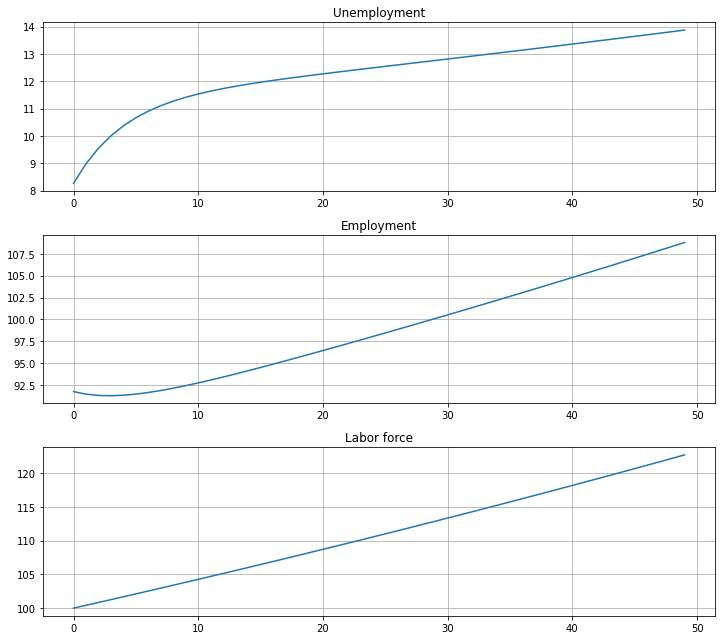

In [16]:
# Here I plot the Aggregate paths of employment, unemployment and labor force
fig, axes = plt.subplots(3, 1, figsize=[10, 9])

axes[0].plot(X_path[:, 0])
axes[0].set_title('Unemployment')
axes[1].plot(X_path[:, 1])
axes[1].set_title('Employment')
axes[2].plot(X_path.sum(1))
axes[2].set_title('Labor force')
for ax in axes:
    ax.grid()
    
plt.tight_layout()
plt.show()

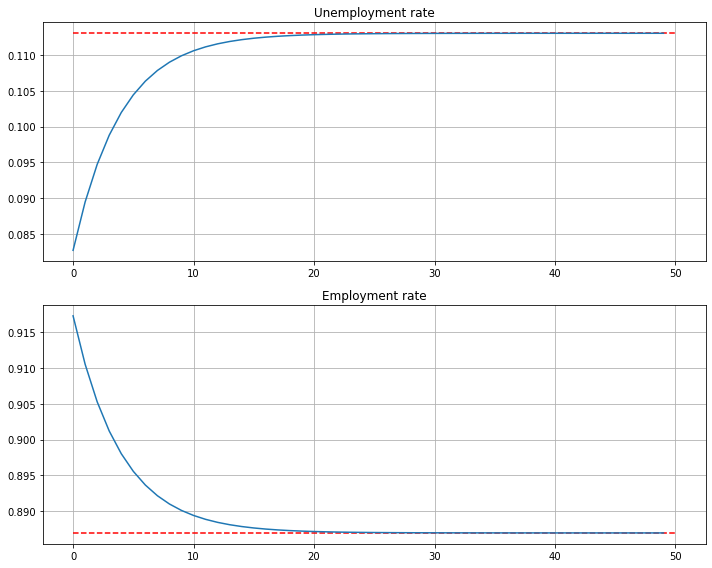

In [22]:
# Here I plot the employment and unemployment rates
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
titles = ['Unemployment rate', 'Employment rate']
for i, title in enumerate(titles):
    axes[i].plot(x_path[:, i])
    axes[i].hlines(xbar[i], 0, T, 'r', '--')
    axes[i].set_title(title)
    axes[i].grid()
plt.tight_layout()
plt.show()

As we can see in the previous plots it takes like 20 periods to converge to the new steady steady and the introduction of this new legislation, that decrease the hiring rate increases the unemployment rate 0.08 to 0.11. In the dynamics of the aggregates, just after the introduction of the shock the aggregate employment decreases a bit, but after that it increases at the same rate g as the aggregate labor force.